In [1]:
!git clone https://github.com/Sanket-DataEnt/groot.git

Cloning into 'groot'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 114 (delta 61), reused 35 (delta 14), pack-reused 0
Receiving objects: 100% (114/114), 172.45 KiB | 6.39 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [1]:
%cd /content/groot/CIFAR

/content/groot/CIFAR


In [3]:
! pip install -U albumentations torch-lr-finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [2]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import Dataset as ds

trainloader = ds.trainloader
testloader =  ds.testloader
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


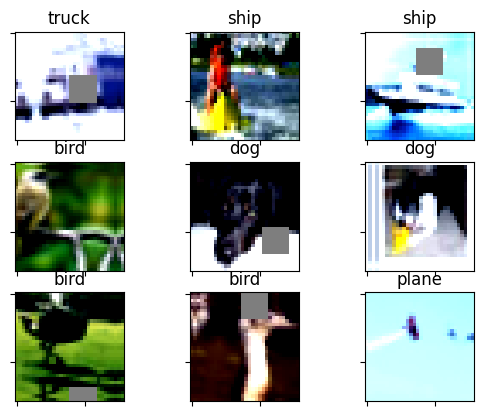

In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# print labels
for i in range(0,9):
 plt.subplot(3, 3, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((images[i]/2)+0.5).numpy(),(1,2,0)))
 plt.title(classes[labels[i]])

In [5]:
import custom_resnet
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = custom_resnet.Net('batch').to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.38E-02


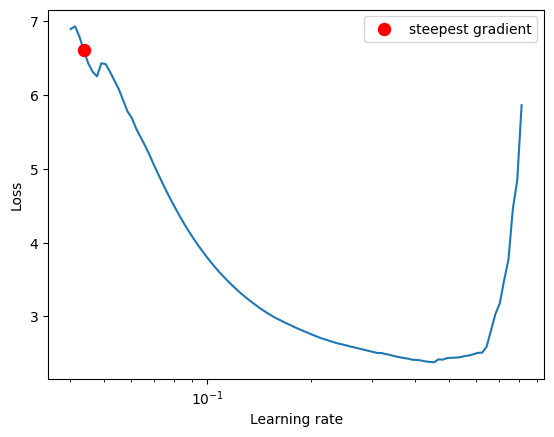

In [6]:
from torch_lr_finder import LRFinder

import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=200, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [7]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
                      optimizer,
                      max_lr=4.38E-02,
                      steps_per_epoch=len(trainloader),
                      epochs=EPOCHS,
		                  pct_start=5/EPOCHS,
                      div_factor=100,
		                  three_phase=False,
                      final_div_factor=100,
		                  anneal_strategy='linear',
                      )

In [8]:
import torch
from tqdm import tqdm
import training, testing
#import test
test_acc = []
train_acc = []
learning_rate = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    scheduler.step()
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train_acc.append(training.train(model, device, trainloader, optimizer, criterion, epoch))
    test_acc.append(testing.test(model, device, testloader))
    learning_rate.append(param_group['lr'])
print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


lr=  0.00046019140225179116


100%|██████████| 391/391 [00:37<00:00, 10.54it/s]


Epoch= 0 Loss=1.1089022159576416 Accuracy=67.50


100%|██████████| 79/79 [00:05<00:00, 14.66it/s]


Accuracy of the network on the 10000 test images: 68.40 %
lr=  0.00048238280450358235


100%|██████████| 391/391 [00:35<00:00, 11.00it/s]


Epoch= 1 Loss=0.6811491847038269 Accuracy=81.25


100%|██████████| 79/79 [00:05<00:00, 15.28it/s]


Accuracy of the network on the 10000 test images: 78.60 %
lr=  0.0005045742067553735


100%|██████████| 391/391 [00:37<00:00, 10.31it/s]


Epoch= 2 Loss=0.7251640558242798 Accuracy=75.00


100%|██████████| 79/79 [00:05<00:00, 14.59it/s]


Accuracy of the network on the 10000 test images: 81.67 %
lr=  0.0005267656090071648


100%|██████████| 391/391 [00:36<00:00, 10.58it/s]


Epoch= 3 Loss=0.5368784666061401 Accuracy=85.00


100%|██████████| 79/79 [00:06<00:00, 11.83it/s]


Accuracy of the network on the 10000 test images: 83.31 %
lr=  0.000548957011258956


100%|██████████| 391/391 [00:40<00:00,  9.64it/s]


Epoch= 4 Loss=0.5005943179130554 Accuracy=87.50


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Accuracy of the network on the 10000 test images: 85.93 %
lr=  0.0005711484135107472


100%|██████████| 391/391 [00:36<00:00, 10.80it/s]


Epoch= 5 Loss=0.6084957718849182 Accuracy=83.75


100%|██████████| 79/79 [00:06<00:00, 12.96it/s]


Accuracy of the network on the 10000 test images: 87.00 %
lr=  0.0005933398157625384


100%|██████████| 391/391 [00:35<00:00, 11.12it/s]


Epoch= 6 Loss=0.5323809385299683 Accuracy=86.25


100%|██████████| 79/79 [00:05<00:00, 14.48it/s]


Accuracy of the network on the 10000 test images: 87.69 %
lr=  0.0006155312180143296


100%|██████████| 391/391 [00:36<00:00, 10.59it/s]


Epoch= 7 Loss=0.6426841020584106 Accuracy=83.75


100%|██████████| 79/79 [00:05<00:00, 14.75it/s]


Accuracy of the network on the 10000 test images: 86.60 %
lr=  0.0006377226202661208


100%|██████████| 391/391 [00:37<00:00, 10.48it/s]


Epoch= 8 Loss=0.3366107940673828 Accuracy=92.50


100%|██████████| 79/79 [00:07<00:00, 10.43it/s]


Accuracy of the network on the 10000 test images: 86.22 %
lr=  0.000659914022517912


100%|██████████| 391/391 [00:35<00:00, 11.12it/s]


Epoch= 9 Loss=0.34948965907096863 Accuracy=91.25


100%|██████████| 79/79 [00:05<00:00, 13.66it/s]


Accuracy of the network on the 10000 test images: 87.20 %
lr=  0.0006821054247697032


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


Epoch= 10 Loss=0.3243710696697235 Accuracy=90.00


100%|██████████| 79/79 [00:05<00:00, 14.57it/s]


Accuracy of the network on the 10000 test images: 89.33 %
lr=  0.0007042968270214943


100%|██████████| 391/391 [00:38<00:00, 10.16it/s]


Epoch= 11 Loss=0.3299710750579834 Accuracy=90.00


100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Accuracy of the network on the 10000 test images: 88.73 %
lr=  0.0007264882292732855


100%|██████████| 391/391 [00:37<00:00, 10.31it/s]


Epoch= 12 Loss=0.2607160210609436 Accuracy=97.50


100%|██████████| 79/79 [00:07<00:00, 10.97it/s]


Accuracy of the network on the 10000 test images: 88.06 %
lr=  0.0007486796315250767


100%|██████████| 391/391 [00:36<00:00, 10.79it/s]


Epoch= 13 Loss=0.2491418421268463 Accuracy=97.50


100%|██████████| 79/79 [00:05<00:00, 13.90it/s]


Accuracy of the network on the 10000 test images: 89.44 %
lr=  0.0007708710337768678


100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


Epoch= 14 Loss=0.26753249764442444 Accuracy=96.25


100%|██████████| 79/79 [00:05<00:00, 14.41it/s]


Accuracy of the network on the 10000 test images: 90.13 %
lr=  0.0007930624360286591


100%|██████████| 391/391 [00:36<00:00, 10.64it/s]


Epoch= 15 Loss=0.30381959676742554 Accuracy=93.75


100%|██████████| 79/79 [00:05<00:00, 14.70it/s]


Accuracy of the network on the 10000 test images: 89.51 %
lr=  0.0008152538382804503


100%|██████████| 391/391 [00:37<00:00, 10.43it/s]


Epoch= 16 Loss=0.3868260383605957 Accuracy=90.00


100%|██████████| 79/79 [00:07<00:00,  9.94it/s]


Accuracy of the network on the 10000 test images: 90.17 %
lr=  0.0008374452405322415


100%|██████████| 391/391 [00:37<00:00, 10.43it/s]


Epoch= 17 Loss=0.46200618147850037 Accuracy=93.75


100%|██████████| 79/79 [00:05<00:00, 13.89it/s]


Accuracy of the network on the 10000 test images: 89.42 %
lr=  0.0008596366427840326


100%|██████████| 391/391 [00:35<00:00, 10.98it/s]


Epoch= 18 Loss=0.2917690575122833 Accuracy=93.75


100%|██████████| 79/79 [00:05<00:00, 14.50it/s]


Accuracy of the network on the 10000 test images: 89.05 %
lr=  0.0008818280450358239


100%|██████████| 391/391 [00:37<00:00, 10.49it/s]


Epoch= 19 Loss=0.4020417630672455 Accuracy=91.25


100%|██████████| 79/79 [00:06<00:00, 12.76it/s]


Accuracy of the network on the 10000 test images: 88.50 %
lr=  0.0009040194472876151


100%|██████████| 391/391 [00:37<00:00, 10.56it/s]


Epoch= 20 Loss=0.4897620677947998 Accuracy=92.50


100%|██████████| 79/79 [00:06<00:00, 11.72it/s]


Accuracy of the network on the 10000 test images: 90.17 %
lr=  0.0009262108495394063


100%|██████████| 391/391 [00:35<00:00, 10.97it/s]


Epoch= 21 Loss=0.230758935213089 Accuracy=93.75


100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


Accuracy of the network on the 10000 test images: 90.15 %
lr=  0.0009484022517911974


100%|██████████| 391/391 [00:35<00:00, 10.94it/s]


Epoch= 22 Loss=0.35777321457862854 Accuracy=93.75


100%|██████████| 79/79 [00:05<00:00, 13.33it/s]


Accuracy of the network on the 10000 test images: 90.77 %
lr=  0.0009705936540429887


100%|██████████| 391/391 [00:38<00:00, 10.11it/s]


Epoch= 23 Loss=0.24699635803699493 Accuracy=98.75


100%|██████████| 79/79 [00:06<00:00, 12.96it/s]

Accuracy of the network on the 10000 test images: 90.58 %
Finished Training


## Train/Test/LR curve

Text(0, 0.5, 'lr')

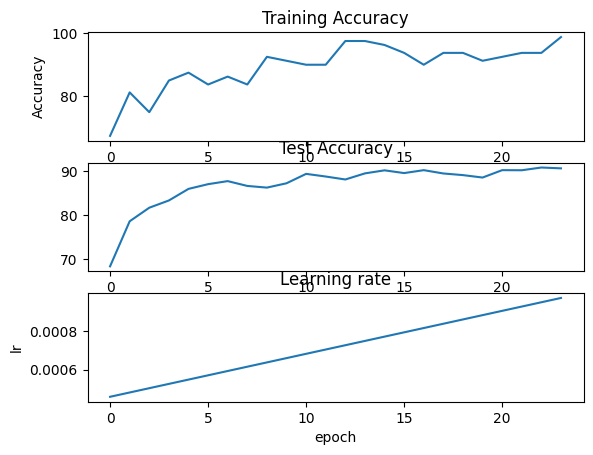

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[2].plot(learning_rate)
axs[2].set_title("Learning rate")
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("lr")

## Misclassified Images

  0%|          | 0/79 [00:03<?, ?it/s]


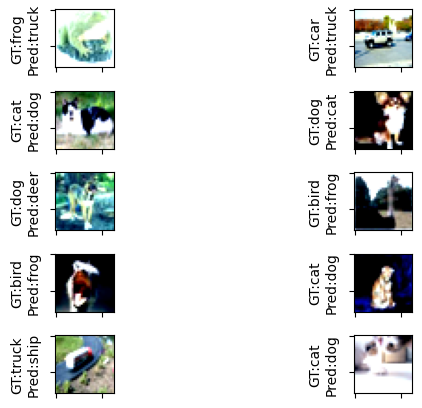

In [11]:
from tqdm import tqdm
model.eval()
missed = []
with torch.no_grad():
      pbar1 = tqdm(testloader)
      for i, (data, target) in enumerate(pbar1):
           data, target = data.to(device), target.to(device)
           outputs = model(data)
           _, predicted = torch.max(outputs.data, 1)
           target1 = target.cpu().numpy()
           predicted1 = predicted.cpu().numpy()
           for i in range(128):
              if target1[i]!=predicted1[i]:
                 missed.append(i)
           break

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(0,10):
 plt.subplot(5, 2, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((data[missed[i]].cpu()/2)+0.5).numpy(),(1,2,0)))
 plt.ylabel("GT:"+str(classes[target1[missed[i]]])+'\nPred:'+str(classes[predicted1[missed[i]]]))

## Correctly classified Images

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/79 [00:04<?, ?it/s]


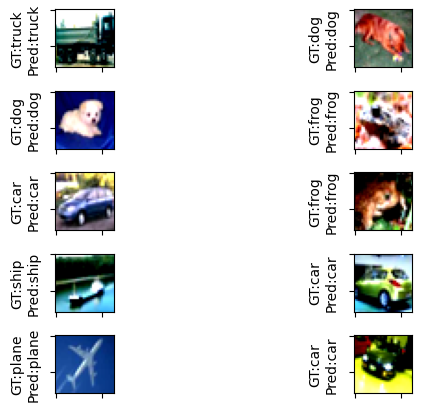

In [12]:
from tqdm import tqdm
model.eval()
missed = []
with torch.no_grad():
      pbar1 = tqdm(testloader)
      for i, (data, target) in enumerate(pbar1):
           data, target = data.to(device), target.to(device)
           outputs = model(data)
           _, predicted = torch.max(outputs.data, 1)
           target1 = target.cpu().numpy()
           predicted1 = predicted.cpu().numpy()
           for i in range(128):
              if target1[i]==predicted1[i]:
                 missed.append(i)
           break

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(0,10):
 plt.subplot(5, 2, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((data[missed[i]].cpu()/2)+0.5).numpy(),(1,2,0)))
 plt.ylabel("GT:"+str(classes[target1[missed[i]]])+'\nPred:'+str(classes[predicted1[missed[i]]]))